## Introduction

The task of the competition [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started) is to build a generative adversarial networks (GAN) that generates 7,000 to 10,000 Monet-style images. I'll try to build the CycleGAN model, which is particularly well-suited for unpaired image-to-image translation tasks like this one, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593).

As we know, a GAN consists of at least two neural networks: a *generator* model and a *discriminator* model. The generator is a neural network that creates the images. this generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

This implementation consisted of several key components:

- Data Preparation: We utilized two distinct datasets:
    - Monet-style images dataset for training.
    - Photos dataset for testing and transformation.
- Model Architecture: The CycleGAN comprised two generator-discriminator pairs:
    - A generator to transform photos into Monet-style images, and its corresponding discriminator.
    - A generator to transform Monet-style images into photos, and its corresponding discriminator.
- Loss Functions: We implemented multiple loss functions to train the model effectively:
    - Adversarial loss to train generators to produce realistic images in each domain.
    - Cycle consistency loss to ensure the preservation of content and structure during transformations.
    - Identity loss to maintain color composition when processing images already in the target domain.
- Training Process: The model was trained using a custom training loop, allowing for fine-grained control over the learning process and detailed monitoring of different loss components.

Finally, based on the competition requirements, we'll use the CycleGAN model to apply Monet-style to the testing photos for submission.

### Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import PIL

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.16.1'

### Dataset

The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`.

The monet directories contain Monet paintings, we'll use these images to train your model.

The photo directories contain photos, we'll add Monet-style to these images and submit generated jpeg images as a zip file, and the submission files limited to 10,000 images.

Also, we'll use TFRecords to efficiently read and store datasets.

## Exploratory Data Analysis

### Load the dataset

In [ ]:
TRAIN_FILES = []
TEST_FILES = []
for dirname, _, filenames in os.walk('../input/gan-getting-started/monet_tfrec'):
    for filename in filenames:
         TRAIN_FILES.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('../input/gan-getting-started/photo_tfrec'):
    for filename in filenames:
         TEST_FILES.append(os.path.join(dirname, filename))

TRAIN_FILES

['../input/gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet08-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet04-60.tfrec',
 '../input/gan-getting-started/monet_tfrec/monet00-60.tfrec']

Now we have the `images.tfrecords` files, let's use the `tf.data.TFRecordDataset` to read the TFRecord files:

In [ ]:
raw_train_ds = tf.data.TFRecordDataset(TRAIN_FILES)
raw_test_ds = tf.data.TFRecordDataset(TEST_FILES)

raw_train_ds

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

We'll use the `tf.train.Example.ParseFromString` function to parse a tensor from dataset and return a `tf.train.Example` object, then we read the features key and value from the `Example` object:

In [ ]:
import numpy as np

for raw_record in raw_train_ds.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    result = {}

# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
    # The values are the Feature objects which contain a `kind` which contains:
    # one of three fields: bytes_list, float_list, int64_list
    kind = feature.WhichOneof('kind')
    result[key] = np.array(getattr(feature, kind).value).dtype

result

{'target': dtype('S5'), 'image': dtype('S29661'), 'image_name': dtype('S10')}

Based on above results, we know that the dataset have 3 features: `image_name`, `target`, `image`, and all features have a string data type.

So, we'll create a description dictionary of the features and create parse function to parse `Example` proto using the description dictonary.

In [ ]:
# Create a description of the features.
feature_description = {
    'target': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_image(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

train_ds = raw_train_ds.map(_parse_image)
test_ds = raw_test_ds.map(_parse_image)

train_ds

<_MapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'target': TensorSpec(shape=(), dtype=tf.string, name=None)}>

Recover the image from the TFRecord file:

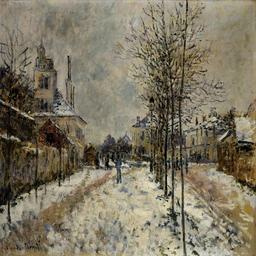

TensorShape([256, 256, 3])

In [ ]:
for image_features in train_ds.take(1):
    image = image_features['image'].numpy()

    image_name = image_features['image_name'].numpy()
    filename = image_name.decode('utf-8')

    target = image_features['target'].numpy()
    label = target.decode('utf-8')

    display.display(display.Image(data=image,alt=label))

# Decode an image file to a uint8 tensor
sample_image = tf.io.decode_jpeg(image)
sample_image.shape

According to the above results, we know the image size is 256x256.

### Preprocessing

As mentioned in the [CycleGAN paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

- In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256.
- In random mirroring, the image is randomly flipped horizontally i.e., left to right.
- Normalize the images to the [-1, 1] range

In [ ]:
# Each image is 256x256 in size
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

- Batch and shuffle dataset

In [ ]:
# The facade training set consist of 300 images
BUFFER_SIZE = 300
BATCH_SIZE = 1

def preprocess_image_train(batch):
    image = batch['image']
    image = tf.io.decode_jpeg(image, channels=CHANNELS)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(batch):
    image = batch['image']
    image = tf.io.decode_jpeg(image, channels=CHANNELS)
    image = normalize(image)
    return image

def create_dataset_train(dataset):
    ds = dataset.map(lambda batch: preprocess_image_train(batch), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

def create_dataset_test(dataset):
    ds = dataset.map(lambda batch: preprocess_image_test(batch), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

train_ds = create_dataset_train(train_ds)
test_ds = create_dataset_test(test_ds)

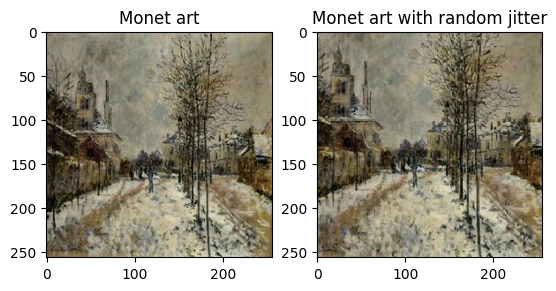

In [ ]:
plt.subplot(121)
plt.title('Monet art')
plt.imshow(sample_image)

plt.subplot(122)
plt.title('Monet art with random jitter')
plt.imshow(random_jitter(sample_image))

## Build the CycleGAN Model

### Build the generator

The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified ResNet based generator. For simplicity, we'll use a modified [U-Net](https://arxiv.org/abs/1505.04597) for generator. A U-Net consists of an downsampler (encoder) and upsampler (decoder).

#### Build the downsampler (encoder)

Structure: Convolution ->  Instance normalization -> Leaky ReLU

> Note that there is no `InstanceNormalization` defined in the keras layers, here we use the `GroupNormalization` with the `group=-1` is the same as the `InstanceNormalization`

In [ ]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = models.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(layers.GroupNormalization(groups=-1))
    result.add(layers.LeakyReLU())
    return result

#### Build the upsampler(decoder)

Structure: Transposed convolution -> Instance normalization -> Dropout (applied to the first 3 blocks) -> ReLU

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = models.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.GroupNormalization(groups=-1))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

#### Generator

Build generator with encoder and decoder:

In [ ]:
def make_generator():
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

### Build the discriminator

The discriminator is a CNN-based image classifier:

In [ ]:
def make_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='input_image')

    x = inputs
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return models.Model(inputs=inputs, outputs=x)

#### Create Generators and Discriminators

In [ ]:
monet_generator = make_generator()
photo_generator = make_generator()
monet_discriminator = make_discriminator()
photo_discriminator = make_discriminator()

Use the discriminator to classify the generated images as reak or fake. The model will be trained to output positive values for real images, and negative values for fake images.

### Define the loss and optimizers

Define loss functions for both models:

In [ ]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. it compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array os 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

#### Generator Loss

The generator's loss function quantifies how well it was able to trick the discriminator. That is, if the generator is performing well, the discriminator will classofy the fake images as real (or 1). It compares the discriminiators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
LAMBDA = 10

def compute_cycle_loss(real_img, cycled_img):
    loss = tf.reduce_mean(tf.abs(real_img - cycled_img))
    return LAMBDA * loss

In [ ]:
def identity_loss(real_img, same_img):
    loss = tf.reduce_mean(tf.abs(real_img - same_img))
    return LAMBDA * 0.5 * loss

#### Optimizers

Initialize the optimizers for all the generators and the discriminators:

In [ ]:
from tensorflow.keras import optimizers

# Optimizers
monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints

This method try to save and restore models, this is helpful in case a long running training task is interrupted.

In [ ]:
CHECKPOINT_DIR = '../working/checkpoints/train'

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           monet_generator_optimizer=monet_generator_optimizer,
                           photo_generator_optimizer=photo_generator_optimizer,
                           monet_discriminator_optimizer=monet_discriminator_optimizer,
                           photo_discriminator_optimizer=photo_discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Training

#### Training loop

The training loop consists of four basic steps:
- Get the predictions
- Calculate the loss
- Calculate the gradients using backpropagation
- Apply the gradients to the optimizer

In [ ]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # real monet -> fake photo
        fake_photo = monet_generator(real_monet, training=True)
        # fake photo -> monet
        cycled_monet = photo_generator(fake_photo, training=True)
        # real photo -> fake monet
        fake_monet = photo_generator(real_photo, training=True)
        # fake monet -> photo
        cycled_photo = monet_generator(fake_monet, training=True)
        # use for identity loss
        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)

        # The discriminators evaluate both real and fake images in each domain
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        # Generator losses: How well the generators fool the discriminators
        monet_gen_loss = generator_loss(disc_fake_photo)
        photo_gen_loss = generator_loss(disc_fake_monet)
        # Cycle consistency loss: Ensures that cycled images are similar to originals
        total_cycle_loss = compute_cycle_loss(real_monet, cycled_monet) + compute_cycle_loss(real_photo, cycled_photo)
        # Identity loss: Encourages generators to preserve input when it's already in the target domain
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        # Discriminator losses: How well the discriminators distinguish real from fake images
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Computes the gradients for each model with respect to its loss.
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)

    # Updates the model parameters using the calculated gradients.
    monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, monet_generator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, photo_generator.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, monet_discriminator.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, photo_discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

def train(monet_dataset, photo_dataset, epochs):
    n = 0
    for epoch in range(epochs):
        start = time.time()
        for monet_image, photo_image in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
            train_step(monet_image, photo_image)
            if n % 10 == 0:
                print ('.', end='')
            n += 1
        clear_output(wait=True)
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec')

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Monet-style Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

#### Train the model



In [ ]:
# Train the model
train(train_ds, test_ds, epochs=EPOCHS)

Saving checkpoint for epoch 30 at ../working/checkpoints/train/ckpt-6
Time taken for epoch 30 is 76.71691966056824 sec


## Results

### Generate Monet-style Images

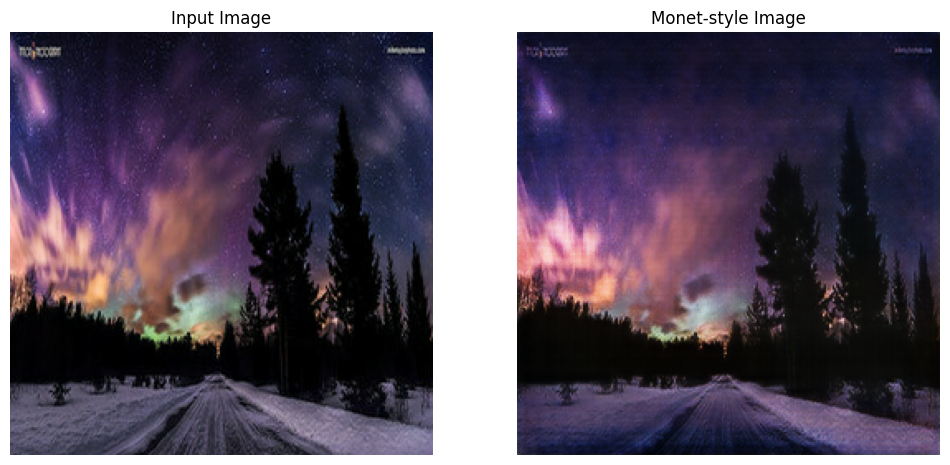

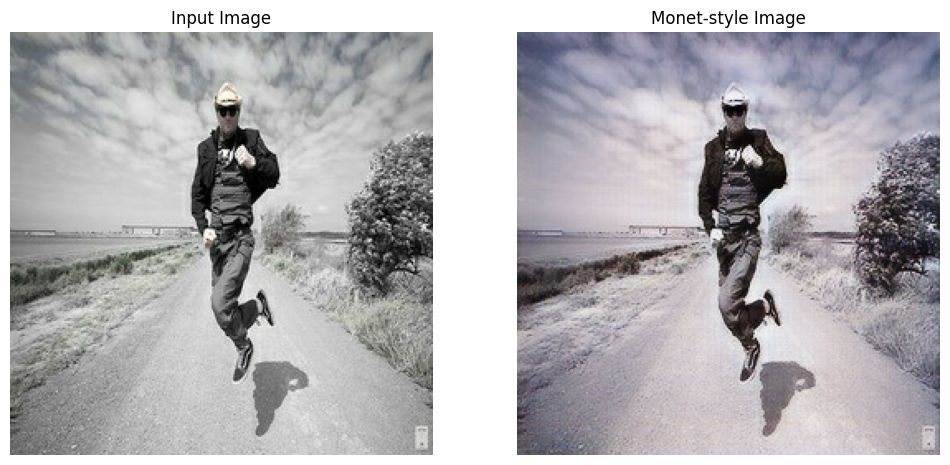

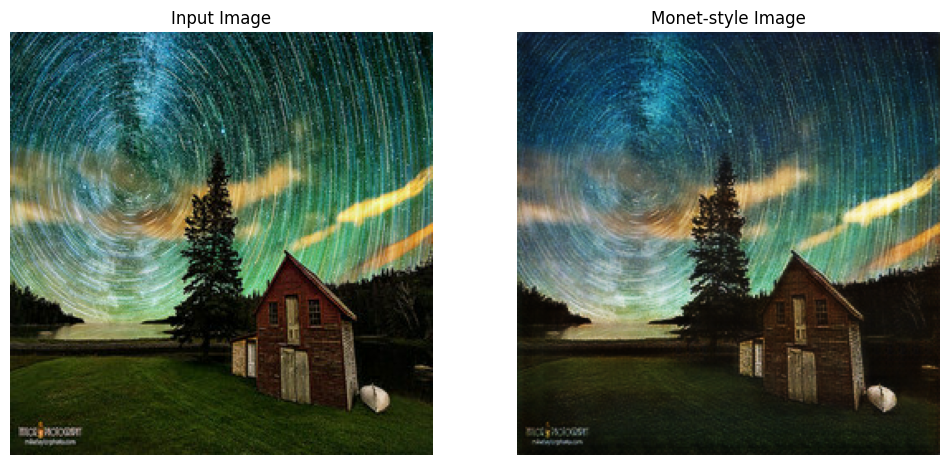

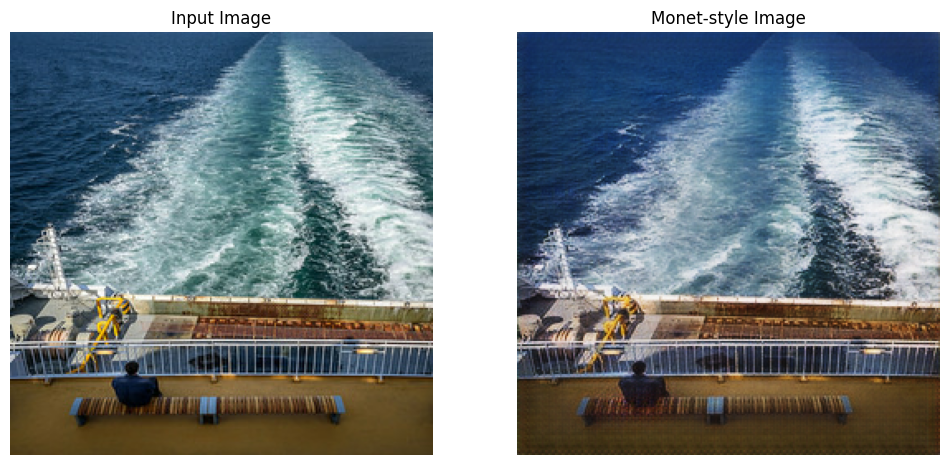

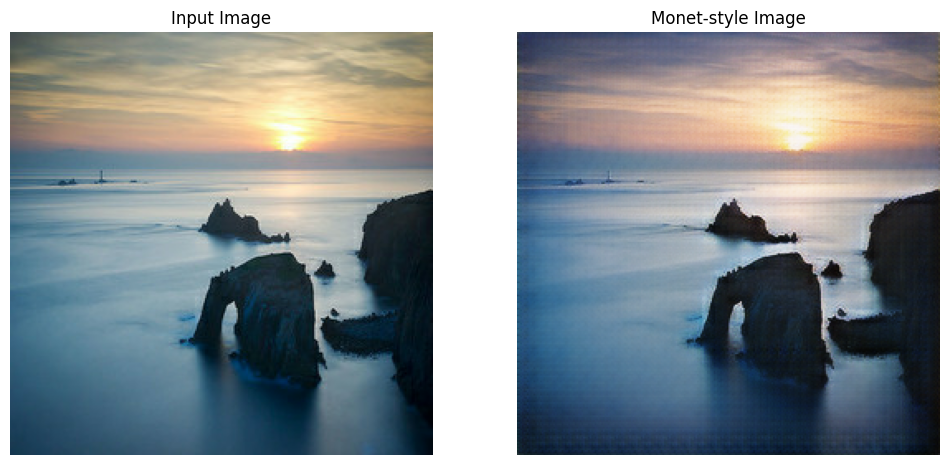

In [ ]:
# Generate Monet-style image from 5 test photos
for photo in test_ds.take(5):
    generate_images(monet_generator, photo)

The implemented CycleGAN model demonstrated good performance in transforming test photos into Monet-style images. Here is my observations:

- Style Transfer Quality: The model successfully captured characteristic elements of Monet's style, including brushstrokes, color palettes, and overall aesthetic.
- Content Preservation: Thanks to the cycle consistency loss, the transformed images maintained the structural integrity and key features of the original photographs.
- Color Composition: The identity loss helped in preserving appropriate color compositions, particularly important when dealing with landscapes and natural scenes.

## Submission

In [ ]:
! mkdir ../images

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import shutil

i = 1
for photo in test_ds:
    prediction = monet_generator(photo, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Conclusion

In this project, we implemented a CycleGAN to transform photos into the Claude Monet style images.

We start with using the TFRecord to read the Monet photos, its benefits include efficiency, flexibility, scalability, integration with TensorFlow, performance, and portability, making it a popular choice for data storage in many machine learning projects. We also explored using the ` tf.train.Example` to read messages from `.tfrecord` files. Also, as per the [CycleGAN paper](https://arxiv.org/abs/1703.10593) mentioned, we apply random jittering and mirroring techniques to the training dataset to avoid overfitting.

In the training phase, the complex training step allows the CycleGAN to learn to translate images between the two domains (Monet-style and photo-style) in both directions, while preserving the content and structure of the original images. Note that we implemented multiple loss functions to train the model effectively. Note that the training can take a long time, especially on CPU, after configured to training with TPU, training is significantly faster than before, the training step shortens a lot of time.

In conclusion, the CycleGAN implementation has successfully bridged the gap between photographs and Monet's artistic style, demonstrating the power of deep learning in creative applications. This project achieves its primary goal of style transfer.

## Reference

- [Tensorflow: TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)
- [Tensorflow: CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan)
- [Tensorflow: Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix)
- [Paper: Generative Adversarial Networks (GAN)](https://arxiv.org/abs/1406.2661)
- [Paper: Image-to-Image Translation with Conditional Adversarial Networks (Pix2Pix)](https://arxiv.org/abs/1611.07004)
- [Paper: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks (CycleGAN)](https://arxiv.org/abs/1703.10593)
